# Greek Supreme Court Legal Decisions: Thematic Analysis

This project focuses on analyzing the themes present in Greek Supreme Court legal decisions. Building upon prior work, this analysis will utilize the Greek Legal Sum dataset, which provides the decision text, a summary, case category, and relevant tags.

In [1]:
import pandas as pd
import pyarrow
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

First we load the dataframe and remove the **subset** column since we will not use it.

In [2]:
df = pd.read_csv("hf://datasets/DominusTea/GreekLegalSum/hugginface_dataset.csv")

In [3]:
df = df.drop('subset', axis=1)
df.head()

,text,summary,case_category,case_tags
0,ΑΡΙΘΜΟΣ 970/2009 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,Αίτηση αναίρεσης καταδικαστικής αποφάσεως για ...,Ακυρότητα απόλυτη,"Αιτιολογίας επάρκεια, Ακυρότητα απόλυτη, Απάτη..."
1,Αριθμός 1692/2009 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,Καθορισμός συνολικής ποινής (άρθρο 551 ΚΠΔ) με...,Ποινή συνολική,"Ποινή συνολική, Νόμου εφαρμογή και ερμηνεία, Ε..."
2,Αριθμός 92/2013 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ Π...,Καταδικαστική απόφαση για μη καταβολή χρεών πρ...,Ακυρότητα απόλυτη,"Ακυρότητα απόλυτη, Αοριστία λόγου αναιρέσεως, ..."
3,Αριθμός 1502/2018 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,Αναίρεση Εισαγγελέα Αρείου Πάγου κατά αθωωτική...,Αβάσιμοι λόγοι,"Αναιρέσεως απόρριψη, Εισαγγελέας Αρείου Πάγου,..."
4,Αριθμός 1501/2018 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,Κατ' εξακολούθηση απάτη κατ' επάγγελμα και κατ...,Αβάσιμοι λόγοι,"Ακυρότητα απόλυτη, Αναιρέσεως απόρριψη, Απάτη,..."


## Exploratory data analysis
Let's find out which case categories and case tags are the most frequent in our documents.

In [4]:
import unicodedata

def remove_greek_tones_and_lowercase(text):
    nfkd_form = unicodedata.normalize('NFD', text)
    without_tones = "".join([c for c in nfkd_form if not unicodedata.combining(c)])
    return without_tones.lower()

In [5]:
def sort_dict_keys(dictionary):
    no_tones_lowercase_d = {}

    for entry in list(dictionary.keys()):
        no_tones_lowercase_entry = remove_greek_tones_and_lowercase(entry)
        no_tones_lowercase_d[no_tones_lowercase_entry] = entry

    return [no_tones_lowercase_d.get(item) for item in sorted(list(no_tones_lowercase_d.keys()))]

In [6]:
# case categories
case_category = df['case_category'].value_counts()
case_category_d = dict(case_category)

case_category_arr = sort_dict_keys(case_category_d)
case_category_values = [case_category_d.get(item) for item in case_category_arr]

# case tags
case_tag = df['case_tags'].value_counts()
case_tag_d = dict(case_tag)

case_tag_arr = sort_dict_keys(case_tag_d)
case_tag_values = [case_tag_d.get(item) for item in case_tag_arr]

In [ ]:
def plot_cases(case_series, case_arr, case_vals, label, fig_size=(50, 16)):
    N_labels = 20
    top_n_for_labels = case_series.nlargest(N_labels)
    category_to_index = {category: i for i, category in enumerate(case_arr)}
    x_tick_labels = [''] * len(case_arr)

    # Populate labels for the top N categories
    for category_name in top_n_for_labels.index:
        idx = category_to_index[category_name]
        x_tick_labels[idx] = category_name

    plt.figure(figsize=fig_size)
    plt.bar(case_arr, case_vals, color='skyblue')
    plt.xlabel(f'{label}')
    plt.ylabel('Frequency')
    plt.title(f"'{label}' distribution")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(case_arr, x_tick_labels, rotation=45, fontsize=8, ha='right')
    plt.tight_layout()
    plt.show()

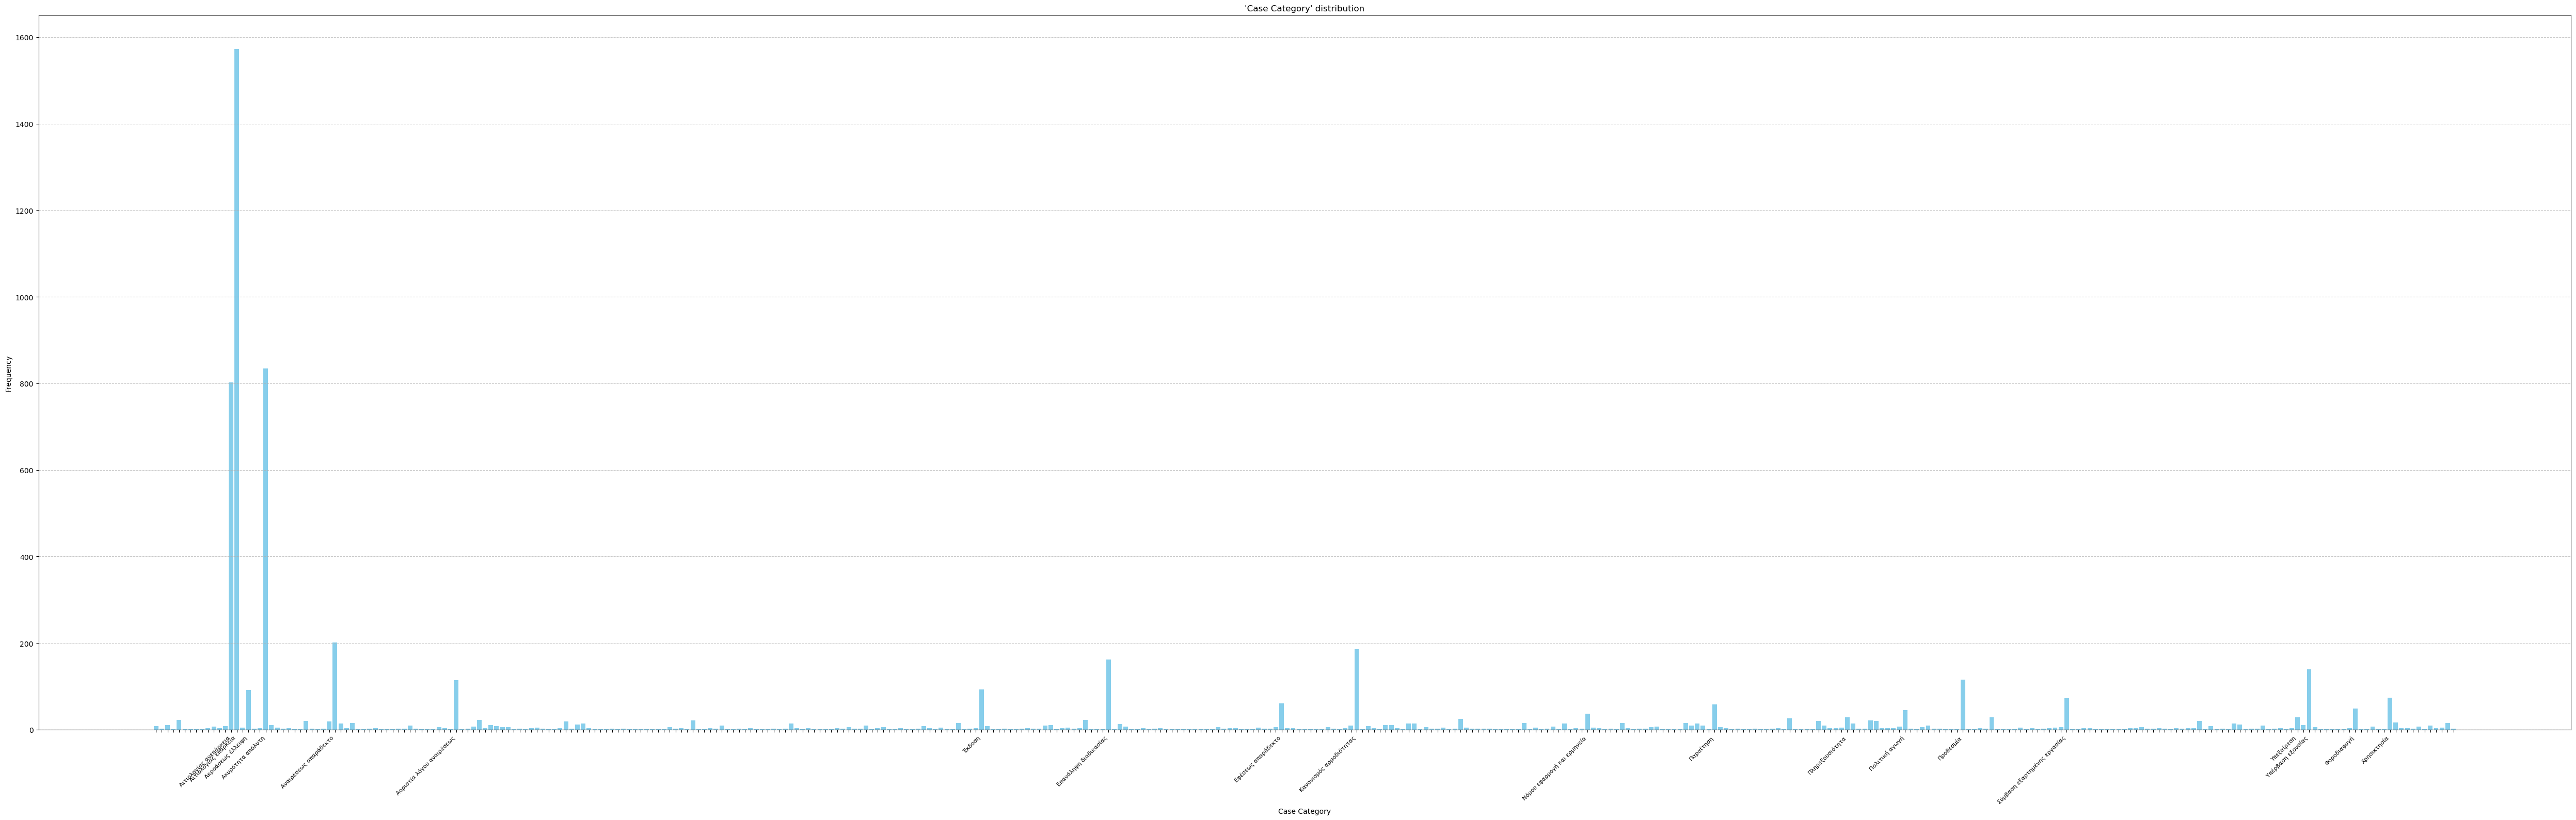

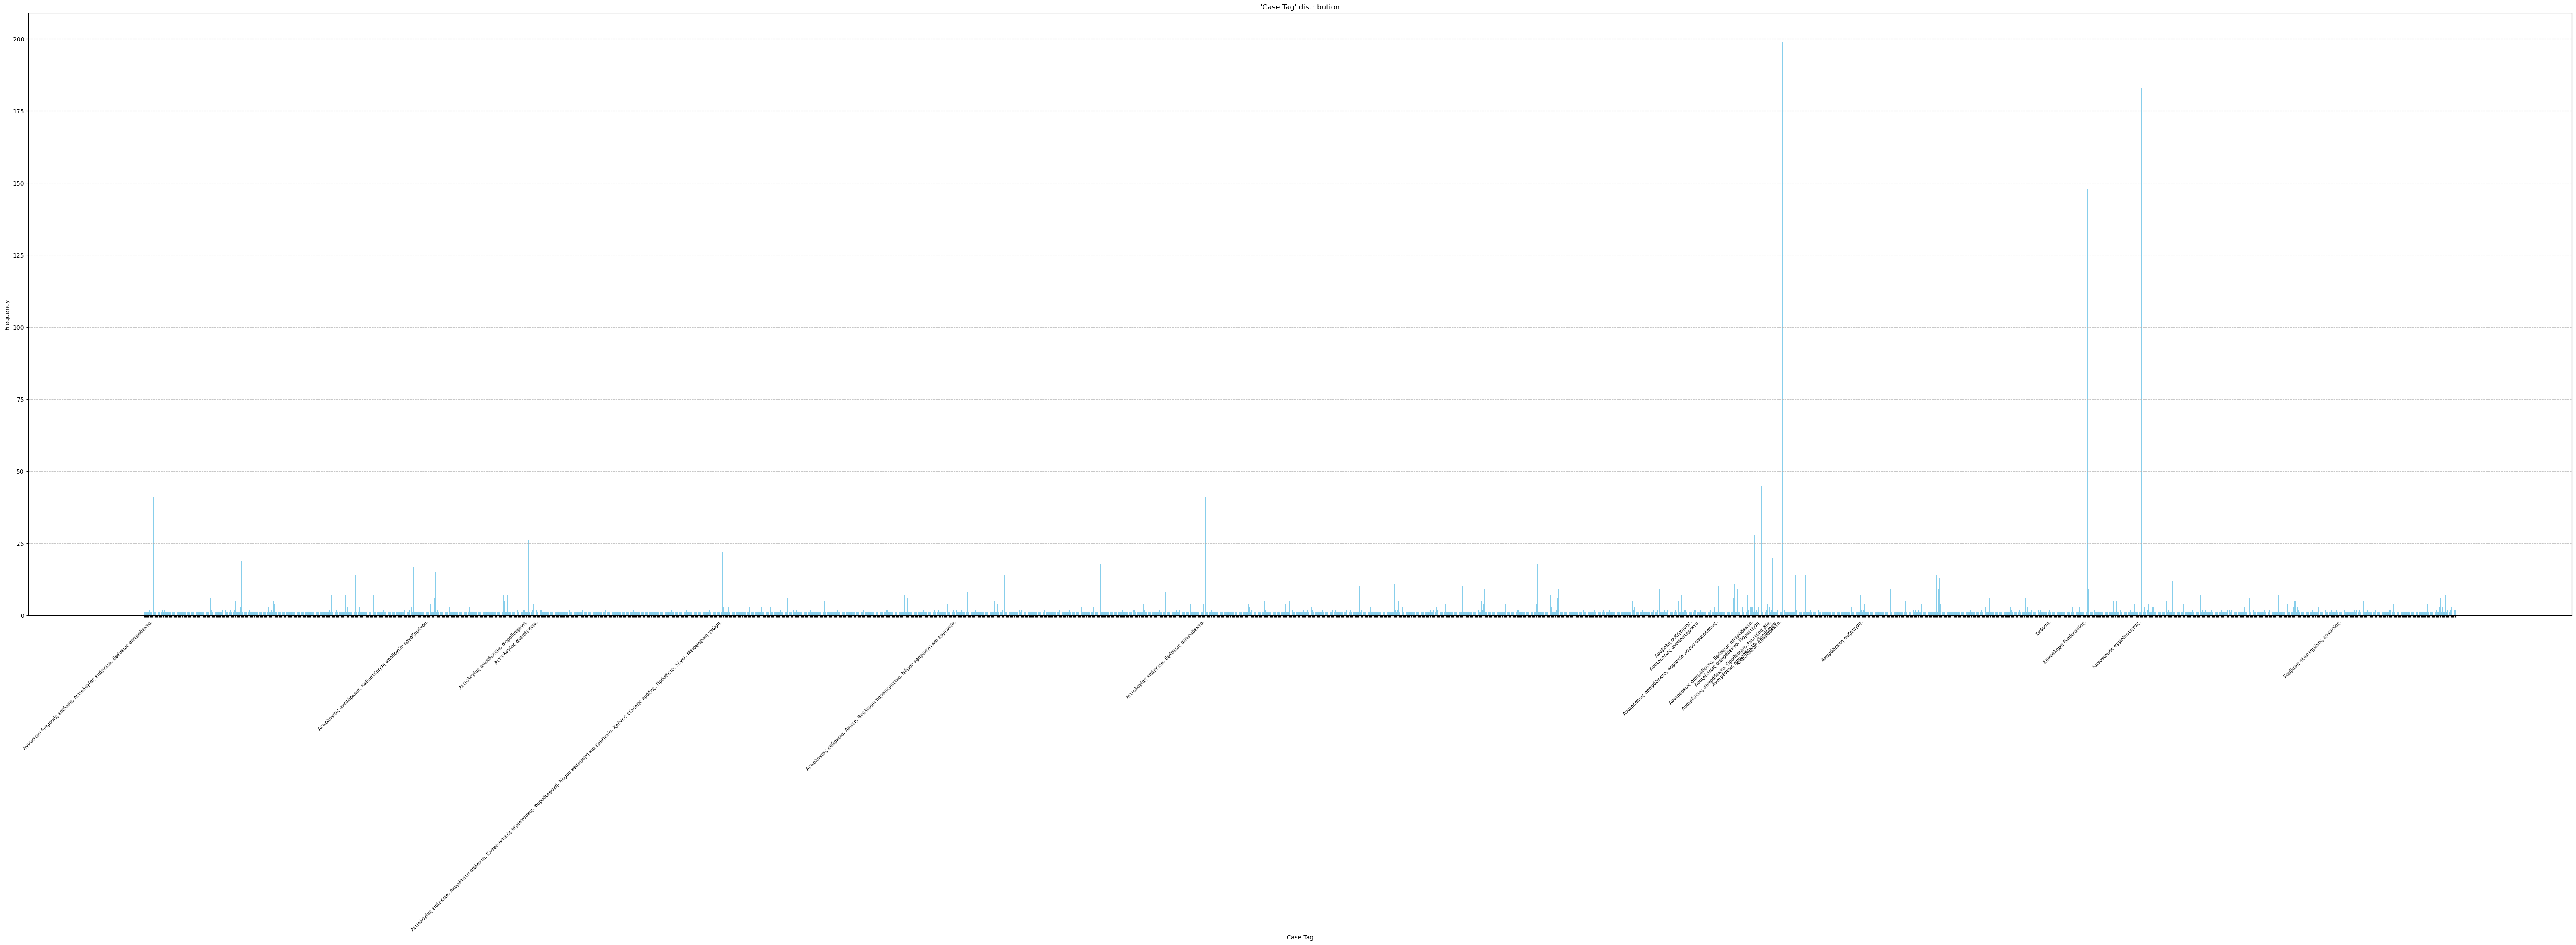

In [ ]:
plot_cases(case_category, case_category_arr, case_category_values, "Case Category")
plot_cases(case_tag, case_tag_arr, case_tag_values, "Case Tag", fig_size=(60, 22))

As we can see in the first diagram, *case category* is dominated by:
1) Αιτιολογίας επάρκεια
2) Ακυρότητα απόλυτη
3) Αιτιολογίας ανεπάρκεια

The most common *case tags* are:
1) Αναιρέσεως απαράδεκτο
2) Κανονισμός αρμοδιότητας
3) Επανάληψη διαδικασίας
4) Αναιρέσεως απαράδκετο, Αοριστία λόγου αναιρέσεως
5) Έκδοση
6) Αναιρέσεως απαράδεκτο, Προθεσμία

## K-means

In [7]:
greek_stopwords = [ # asked an LLM to give a list with the most common modern greek words
    "ο", "η", "το", "οι", "τα", "του", "της", "των", "με", "σε", "για", "από", "θα", "είναι", "και", "πως", "που", "με", "αλλά", "δεν", "είχα", "είχες", "είχε", "είχαμε", "είχατε", "είχαν", "έχω", "έχεις", "έχει", "έχουμε", "έχετε", "έχουν", "μου", "σου", "του", "της", "μας", "σας", "τους", "ότι", "αυτό", "αυτή", "αυτό", "αυτά", "αυτές", "αυτοί", "αυτού", "αυτής", "αυτούς", "αυτού", "αυτές", "όλα", "όλες", "όλοι", "κάθε", "πολύ", "πολλά", "λιγότερο", "περισσότερο", "επίσης", "προς", "πριν", "μετά", "μέσα", "έξω", "πάνω", "κάτω", "μαζί", "μόνο", "τέλος", "αρχή", "πάντα", "ποτέ", "σήμερα", "αύριο", "χθες", "αν", "ή", "είτε", "ούτε", "μήτε", "διότι", "επειδή", "δηλαδή", "ακόμα", "ποτέ", "κανείς", "τίποτα", "όπως", "σχετικά", "παρά", "χωρίς", "όταν", "όπου", "ενώ", "αφότου", "εάν", "μόλις", "έως", "μέχρι", "αμέσως", "μάλιστα", "μόνον", "γενικά", "συχνά", "σπάνια", "πρώτα", "ύστερα", "τότε", "τώρα", "ξανά", "εδώ", "εκεί", "αλλού", "μέσω", "χάρη", "λόγω", "μέχρι", "κατά", "αναλόγως", "παρά", "αντί", "εναντίον", "υπέρ", "πριν", "μετά", "προς", "επι", "υπο", "δια", "συν", "κατά", "ανα", "αντι", "απο", "εξ", "εν", "επι", "ευ", "κατα", "μετα", "περι", "προ", "προσ", "συν", "υπερ", "υπο", "χωρίς", "μεταξύ", "πάντα", "κάθε"
]

In [8]:
texts = df['summary'].to_list()
true_categories = df['case_category'].tolist()

true_tags = []
for tag_string in df['case_tags'].tolist():
    if (type(tag_string) == str):
        tags_list = [tag.strip() for tag in tag_string.split(',') if tag.strip()]
    else:
        tags_list = []
    true_tags.append(tags_list)


In [9]:
import string
import re
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

def preprocess_text(text):
    text = text.lower() # lowercasing
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    text = re.sub(r'\d+', '', text) # remove numbers
    tokens = word_tokenize(text, language='greek')
    tokens = [word for word in tokens if word not in greek_stopwords and len(word) > 1] # remove stopwords and words that are one character long
    return " ".join(tokens)

preprocessed_texts = [preprocess_text(text) for text in texts]

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, normalized_mutual_info_score

tfidf_vectorizer = TfidfVectorizer(max_features=10000)
preprocessed_texts_sm = tfidf_vectorizer.fit_transform(preprocessed_texts)

In [ ]:
ground_truth_tags_str = ["_".join(tags) for tags in true_tags] # we will concatenate the tags of each text into a string and use that as our ground truth for the category tags
k_range = range(2, 50)

micro_silhouette_scores = []
macro_silhouette_scores = []
nmi_category_scores = []
nmi_tag_scores = []
for k in k_range:
    # create clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(preprocessed_texts_sm)

    # compute silhouette score
    silhouette_average = silhouette_score(preprocessed_texts_sm, labels)
    micro_silhouette_scores.append(silhouette_average)

    sample_silhouette_values = silhouette_samples(preprocessed_texts_sm, labels)
    cluster_avg_silhouettes = []
    for i in range(k):
        cluster_i_samples = sample_silhouette_values[labels == i]
        cluster_avg_silhouettes.append(np.mean(cluster_i_samples))
    macro_sil = np.mean(cluster_avg_silhouettes)
    macro_silhouette_scores.append(macro_sil)

    # NMI for Case Category
    nmi_category = normalized_mutual_info_score(true_categories, labels)
    nmi_category_scores.append(nmi_category)

    # NMI for Case Tags (using concatenated tags as ground truth)
    nmi_tag = normalized_mutual_info_score(ground_truth_tags_str, labels)
    nmi_tag_scores.append(nmi_tag)

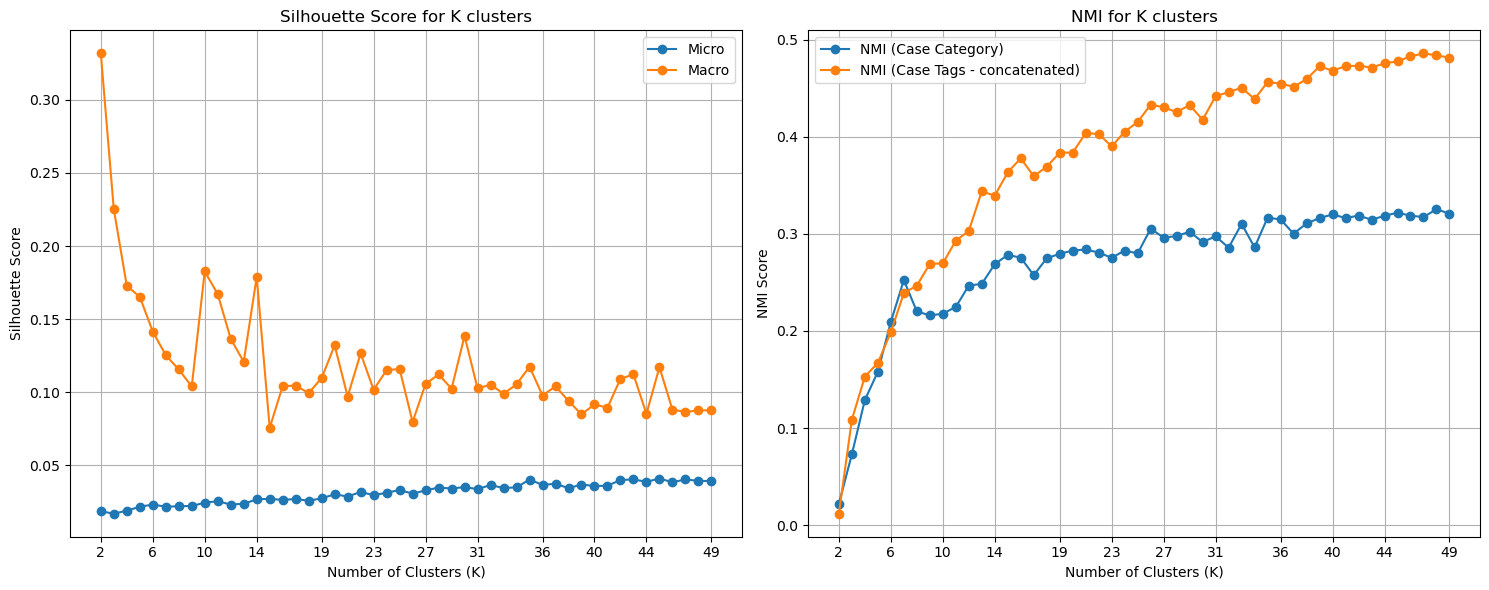


--- Analysis of Results ---
Micro-Aggregated Silhouette Scores: ['0.019', '0.017', '0.019', '0.022', '0.023', '0.022', '0.022', '0.022', '0.024', '0.025', '0.023', '0.024', '0.027', '0.027', '0.026', '0.027', '0.026', '0.027', '0.030', '0.029', '0.032', '0.030', '0.031', '0.033', '0.031', '0.033', '0.035', '0.034', '0.035', '0.034', '0.037', '0.034', '0.035', '0.040', '0.037', '0.037', '0.034', '0.037', '0.036', '0.036', '0.040', '0.040', '0.039', '0.041', '0.038', '0.040', '0.039', '0.039']
Macro-Aggregated Silhouette Scores: ['0.332', '0.225', '0.173', '0.165', '0.142', '0.125', '0.116', '0.104', '0.183', '0.167', '0.137', '0.121', '0.179', '0.076', '0.104', '0.104', '0.099', '0.110', '0.132', '0.097', '0.127', '0.102', '0.115', '0.116', '0.080', '0.106', '0.112', '0.102', '0.139', '0.103', '0.105', '0.099', '0.105', '0.117', '0.098', '0.104', '0.094', '0.085', '0.092', '0.089', '0.109', '0.112', '0.085', '0.117', '0.088', '0.087', '0.088', '0.088']
NMI (Case Category) Scores: ['0.0

In [ ]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(list(k_range), micro_silhouette_scores, marker='o', label='Micro')
plt.plot(list(k_range), macro_silhouette_scores, marker='o', label='Macro')
plt.title('Silhouette Score for K clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.xticks(np.linspace(2, list(k_range)[-1], (list(k_range)[-1] - 1) // 4, dtype=int))

plt.subplot(1, 2, 2)
plt.plot(list(k_range), nmi_category_scores, marker='o', label='NMI (Case Category)')
plt.plot(list(k_range), nmi_tag_scores, marker='o', label='NMI (Case Tags - concatenated)')
plt.title('NMI for K clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('NMI Score')
plt.legend()
plt.grid(True)
plt.xticks(np.linspace(2, list(k_range)[-1], (list(k_range)[-1] - 1) // 4, dtype=int))

plt.tight_layout()
plt.show()

print("\n--- Analysis of Results ---")
print("Micro-Aggregated Silhouette Scores:", [f"{s:.3f}" for s in micro_silhouette_scores])
print("Macro-Aggregated Silhouette Scores:", [f"{s:.3f}" for s in macro_silhouette_scores])
print("NMI (Case Category) Scores:", [f"{s:.3f}" for s in nmi_category_scores])
print("NMI (Case Tags) Scores:", [f"{s:.3f}" for s in nmi_tag_scores])

if micro_silhouette_scores:
    optimal_k_micro_sil = k_range[np.argmax(micro_silhouette_scores)]
    print(f"\nOptimal K based on Micro-Aggregated Silhouette Score: {optimal_k_micro_sil} (Score: {max(micro_silhouette_scores):.3f})")
if macro_silhouette_scores:
    optimal_k_macro_sil = k_range[np.argmax(macro_silhouette_scores)]
    print(f"Optimal K based on Macro-Aggregated Silhouette Score: {optimal_k_macro_sil} (Score: {max(macro_silhouette_scores):.3f})")
if nmi_category_scores:
    optimal_k_nmi_category = k_range[np.argmax(nmi_category_scores)]
    print(f"Optimal K based on NMI (Case Category): {optimal_k_nmi_category} (Score: {max(nmi_category_scores):.3f})")
if nmi_tag_scores:
    optimal_k_nmi_tag = k_range[np.argmax(nmi_tag_scores)]
    print(f"Optimal K based on NMI (Case Tags): {optimal_k_nmi_tag} (Score: {max(nmi_tag_scores):.3f})")

Let's analyze the results.
</br></br>
**Micro-Silhouette Score**: The curve steadily increases as we increase the number of K but with a very small rate, which doesn't indicate which K is truly the best.
</br></br>
**Macro-Silhouette Score**: The silhouette score is at its peak for K=2 and then drops. However we can see a peak at *K=10* - *K=14* with a silhouette score of approximately 0.17 and then a steady decrease after that.
</br></br>
**NMI (for Case Category)**: The rate of increase slows down after *K=7*.
</br></br>
**NMI (for Case Tags)**: There is a consistent increase through the whole range of K, slowing down at around *K=39* and reaching it's peak at *K=47*.
</br></br>
We need to find a K that balances good silhouette and high NMI, so we can have a reasonable number of clusters and good cluster quality. If we consider where the rate of gain starts to slow down a good fit for K would be around **K=14**.

In [11]:
from sklearn.manifold import TSNE
import seaborn as sns

def custom_kmeans(k):
    # k-means for decided K
    chosen_k = k
    kmeans_final = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
    labels_final = kmeans_final.fit_predict(preprocessed_texts_sm)

    # apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, preprocessed_texts_sm.shape[0]-1))
    tsne_results = tsne.fit_transform(preprocessed_texts_sm.toarray())

    # apply t-SNE for cluster centroids
    tsne_centroids = TSNE(n_components=2, random_state=42, perplexity=min(30, kmeans_final.cluster_centers_.shape[0]-1))
    tsne_centroids_results = tsne_centroids.fit_transform(kmeans_final.cluster_centers_)

    # find centroids
    centroids_2d = []
    for i in range(chosen_k):
        cluster_points = tsne_results[labels_final == i]
        if len(cluster_points) > 0:
            centroids_2d.append(np.mean(cluster_points, axis=0))
        else:
            centroids_2d.append(np.array([np.nan, np.nan]))
    centroids_2d = np.array(centroids_2d)

    clusters_df = pd.DataFrame(data=tsne_results, columns=["tsne1", "tsne2"])
    clusters_df['Cluster'] = labels_final
    clusters_df['True Category'] = true_categories
    clusters_df['Summary'] = texts
    display(clusters_df.head())

    cluster_centers_df = pd.DataFrame(data=centroids_2d, columns=["tsne1", "tsne2"])
    cluster_centers_df['Cluster'] = range(chosen_k)
    display(cluster_centers_df.head())


    color_palette = sns.color_palette("tab20", n_colors=chosen_k)

    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        x="tsne1", y="tsne2",
        hue="Cluster",
        palette=color_palette,
        data=clusters_df,
        legend="auto",
        alpha=0.7
    )
    sns.scatterplot(
        x="tsne1", y="tsne2",
        data=cluster_centers_df,
        hue="Cluster",
        palette=color_palette,
        alpha=0.7,
        s=300,
        edgecolor='black',
        zorder=5,
        marker='X'
    )
    plt.title(f't-SNE Visualization of K-Means Clusters (K={chosen_k})')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True)
    plt.show()

    return kmeans_final

,tsne1,tsne2,Cluster,True Category,Summary
0,34.128353,-4.576652,10,Ακυρότητα απόλυτη,Αίτηση αναίρεσης καταδικαστικής αποφάσεως για ...
1,11.722866,15.343945,4,Ποινή συνολική,Καθορισμός συνολικής ποινής (άρθρο 551 ΚΠΔ) με...
2,-9.824346,-37.342213,0,Ακυρότητα απόλυτη,Καταδικαστική απόφαση για μη καταβολή χρεών πρ...
3,21.137325,-10.700757,12,Αβάσιμοι λόγοι,Αναίρεση Εισαγγελέα Αρείου Πάγου κατά αθωωτική...
4,29.411533,6.848886,12,Αβάσιμοι λόγοι,Κατ' εξακολούθηση απάτη κατ' επάγγελμα και κατ...


,tsne1,tsne2,Cluster
0,10.093690,-3.567822,0
1,-12.482261,21.543854,1
2,9.463202,14.738472,2
3,-8.048846,2.235654,3
4,-6.577271,18.264380,4


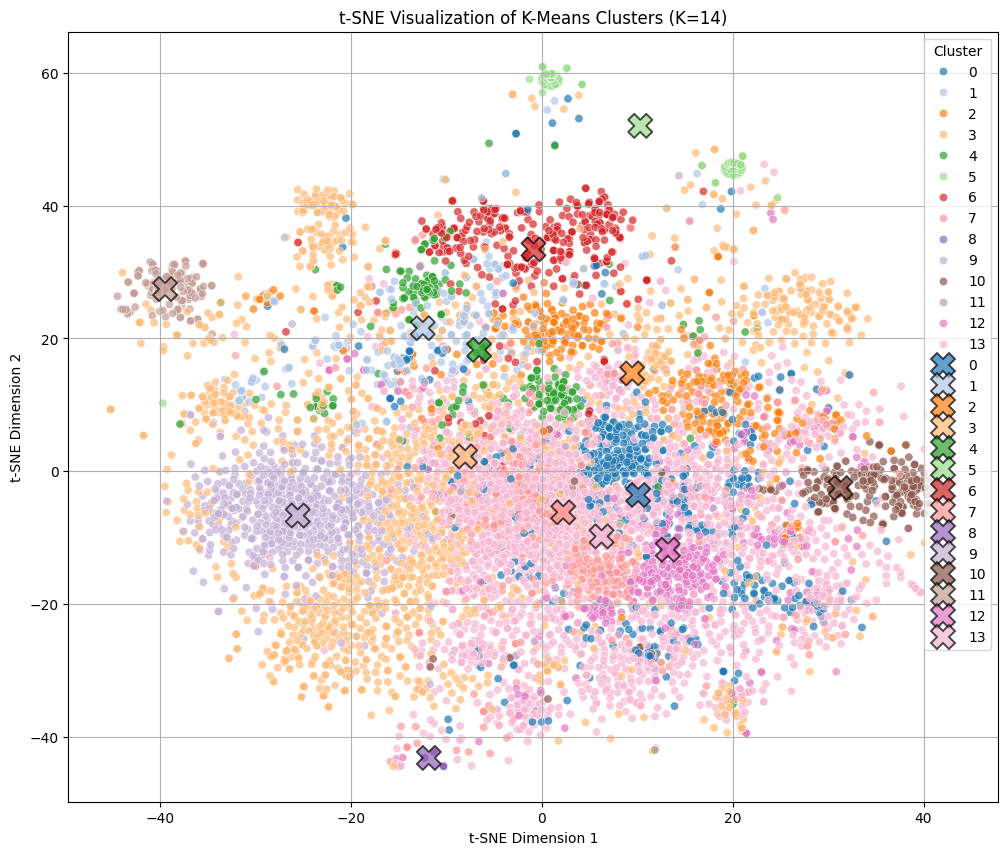

In [ ]:
kmeans_final = custom_kmeans(14)

Some clusters are very distinguishable, such as 11, 5, 6, 12, 13, 3, 2 and 8.
What is really interesting is the spread of the points in clusters 4 and 7. Neither of them form a distinct grouping. This indicates that our Kmeans algorithm couldn't find well-seperated groups for these clusters. Maybe the problem lies in our decision to use K=14. What if we try with another K?

,tsne1,tsne2,Cluster,True Category,Summary
0,-36.162746,15.287762,8,Ακυρότητα απόλυτη,Αίτηση αναίρεσης καταδικαστικής αποφάσεως για ...
1,2.361906,38.858326,3,Ποινή συνολική,Καθορισμός συνολικής ποινής (άρθρο 551 ΚΠΔ) με...
2,1.458820,-8.339063,25,Ακυρότητα απόλυτη,Καταδικαστική απόφαση για μη καταβολή χρεών πρ...
3,-38.106277,32.098438,14,Αβάσιμοι λόγοι,Αναίρεση Εισαγγελέα Αρείου Πάγου κατά αθωωτική...
4,-34.787857,29.961529,18,Αβάσιμοι λόγοι,Κατ' εξακολούθηση απάτη κατ' επάγγελμα και κατ...


,tsne1,tsne2,Cluster
0,40.961819,-1.180430,0
1,41.130951,-23.767754,1
2,61.887405,-25.026432,2
3,22.523037,25.270777,3
4,-15.272566,68.033936,4


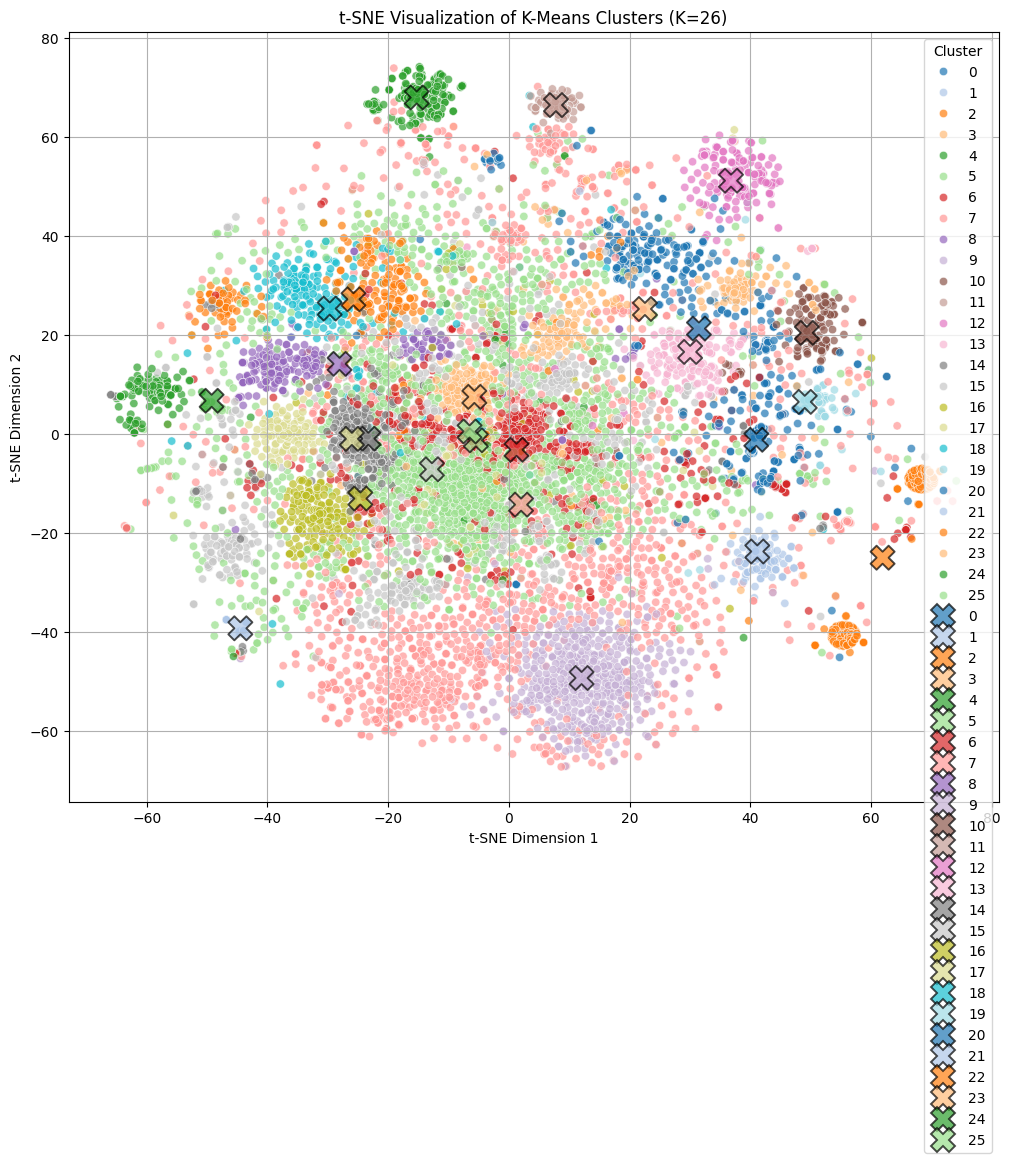

In [12]:
kmeans_final = custom_kmeans(26)

## LLM for title extraction

First we need to make sure that we have everything set up.

In [3]:
import os

os.environ["HF_HOME"] = "D:\HuggingFaceCache"
print(f"HF_HOME environment variable: {os.getenv('HF_HOME')}")

HF_HOME environment variable: D:\HuggingFaceCache


In [4]:
from huggingface_hub import login

login()

In [5]:
!pip uninstall bitsandbytes accelerate transformers huggingface_hub torch torchvision torchaudio

Found existing installation: accelerate 1.6.0
Uninstalling accelerate-1.6.0:
  Would remove:
    /usr/local/bin/accelerate
    /usr/local/bin/accelerate-config
    /usr/local/bin/accelerate-estimate-memory
    /usr/local/bin/accelerate-launch
    /usr/local/bin/accelerate-merge-weights
    /usr/local/lib/python3.11/dist-packages/accelerate-1.6.0.dist-info/*
    /usr/local/lib/python3.11/dist-packages/accelerate/*
Proceed (Y/n)? y
  Successfully uninstalled accelerate-1.6.0
Found existing installation: transformers 4.51.3
Uninstalling transformers-4.51.3:
  Would remove:
    /usr/local/bin/transformers-cli
    /usr/local/lib/python3.11/dist-packages/transformers-4.51.3.dist-info/*
    /usr/local/lib/python3.11/dist-packages/transformers/*
Proceed (Y/n)? y
  Successfully uninstalled transformers-4.51.3
Found existing installation: huggingface-hub 0.31.2
Uninstalling huggingface-hub-0.31.2:
  Would remove:
    /usr/local/bin/huggingface-cli
    /usr/local/lib/python3.11/dist-packages/hugg

In [6]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 102.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 94.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/19

In [1]:
!pip install bitsandbytes==0.43.2 --extra-index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 8.6 MB/s eta 0:00:00


In [2]:
!pip install accelerate transformers huggingface_hub --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.1/362.1 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.4/509.4 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 96.3 MB/s eta 0:00:00


In [5]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"PyTorch CUDA version: {torch.version.cuda}")
    print(f"PyTorch CUDA device name: {torch.cuda.get_device_name(0)}")
else:
    print("PyTorch does not detect CUDA. Ensure GPU drivers are installed and PyTorch is installed with CUDA support.")

CUDA available: False
PyTorch does not detect CUDA. Ensure GPU drivers are installed and PyTorch is installed with CUDA support.


After installing all the necessary packages, we load the model. We will use **google/gemma-7b-it**.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_name = "google/gemma-7b-it"

nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_name)

try:
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=nf4_config,
        device_map="auto",
        torch_dtype=torch.bfloat16,
        trust_remote_code=True,
    )
    print("Model loaded with 4-bit quantization and device_map='auto'.")
except Exception as e:
    print(f"Error loading model with GPU optimization, trying without device_map or quantization (might require more VRAM): {e}")
    try:
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            trust_remote_code=True
        ).to("cpu") # move to CPU if no GPU
        print("Model loaded on CPU (or GPU without quantization/device_map). Performance might vary.")
    except Exception as e_fallback:
        print(f"Fallback model loading failed: {e_fallback}")
        model = None

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

CUDA is required but not available for bitsandbytes. Please consider installing the multi-platform enabled version of bitsandbytes, which is currently a work in progress. Please check currently supported platforms and installation instructions at https://huggingface.co/docs/bitsandbytes/main/en/installation#multi-backend


Error loading model with GPU optimization, trying without device_map or quantization (might require more VRAM): CUDA is required but not available for bitsandbytes. Please consider installing the multi-platform enabled version of bitsandbytes, which is currently a work in progress. Please check currently supported platforms and installation instructions at https://huggingface.co/docs/bitsandbytes/main/en/installation#multi-backend


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Collect all the data in the form of a dictionary with the keys:
- id
- text
- features

This way it will be easy to do the 3-shot learning.

In [ ]:
num_decisions, num_features = preprocessed_texts_sm.shape[0], preprocessed_texts_sm.shape[1]
n_clusters = 26

decisions_data = []
for i in range(num_decisions):
    decisions_data.append({
        'id': i,
        'text': df.iloc[i]['summary'],
        'features': preprocessed_texts_sm[i]
    })

data_clusters = {i: label for i, label in enumerate(kmeans_final.labels_)}
centroids = {i: kmeans_final.cluster_centers_[i] for i in range(kmeans_final.n_clusters)}

Get the closest data points to their centroid for the current cluster. These points are supposed to be the most representative for the cluster.

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
from scipy.sparse import csr_matrix

def get_cluster_decisions(cluster_id, decisions_data, data_clusters, centroids, num_samples=3, mode='closest'):
    # get only the decisions that are assigned to this cluster
    cluster_decisions = []
    for d in decisions_data:
        if data_clusters[d['id']] == cluster_id:
            cluster_decisions.append(d)

    # check if there are less decisions assigned to the cluster than the number we want to extract
    if (len(cluster_decisions) < num_samples):
        print(f"Warning: Cluster {cluster_id} has fewer than {num_samples} decisions. Returning all available.")
        return [d['text'] for d in cluster_decisions]

    if mode == 'closest': # compute euclidean diastance to get the n_samples data points nearest to their centroid
      distances = []
      for d in cluster_decisions:
          dist = euclidean_distances(d['features'], csr_matrix(centroids[cluster_id]))[0][0]
          distances.append((dist, d['text']))

      distances.sort(key=lambda x: x[0])

      return [text for _, text in distances[:num_samples]]
    else: # choose random data points
      return [d['text'] for d in np.random.choice(cluster_decisions, num_samples, replace=False)]


Call the LLM with the model we created earlier.

In [ ]:
def call_llm(prompt):
    if model is None or tokenizer is None:
        print("Error: LLM model or tokenizer not loaded. Cannot generate title.")
        return "Κοινό Θέμα:\nLLM Not Available."

    try:
        messages = [
            {"role": "user", "content": prompt}
        ]


        input_ids = tokenizer.apply_chat_template(
            messages,
            add_generation_prompt=True,
            return_tensors="pt"
        ).to(model.device)

        outputs = model.generate(
            input_ids,
            max_new_tokens=50, # concise title
            do_sample=False,
            num_return_sequences=1,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

        generated_text_with_prompt = tokenizer.decode(outputs[0], skip_special_tokens=True)
        input_prompt_decoded = tokenizer.decode(input_ids[0], skip_special_tokens=True)
        model_generated_part = generated_text_with_prompt[len(input_prompt_decoded):].strip()

        match = re.search(r"\*\*(.*?)\*\*", model_generated_part, re.DOTALL)
        generated_title = match.group(1).strip()
        generated_title = generated_title.replace('\n', ' ').replace('\r', '').strip()

        return f"Κοινό Θέμα:\n{generated_title}"

    except Exception as e:
        print(f"Error during LLM title generation: {e}")
        import traceback
        traceback.print_exc()
        return "Κοινό Θέμα:\nΣφάλμα Κατά τη Δημιουργία Τίτλου."

Create the prompt we want to give our LLM and then get the result after calling it.

In [ ]:
def generate_cluster_title(sampled_texts):
    if not sampled_texts:
        return "Δεν βρέθηκαν κείμενα για αυτή τη συστάδα."

    prompt = (
        f"Σου δίνονται {len(sampled_texts)} κείμενα νομικών αποφάσεων που ανήκουν στην ίδια κατηγορία. "
        "Ποιο είναι το κοινό κεντρικό θέμα που περιγράφουν αυτές οι αποφάσεις; "
        "Ο τίτλος πρέπει να είναι σύντομος και περιεκτικός.'\n\n"
    )

    # truncate text if it is too long for the prompt
    for i, text in enumerate(sampled_texts):
        extracted_text = text
        if (len(text) > 500):
            extracted_text = text[:500] + "..."

        prompt += f"\nΚείμενο {i+1}: {extracted_text}\n"

    prompt += "\nΚοινό Θέμα:\n"

    llm_response = call_llm(prompt)

    # extract LLM's response with regex
    match = re.search(r"Κοινό Θέμα:\n(.+)", llm_response, re.DOTALL)
    if match:
        return match.group(1).strip()
    else:
        return "Δεν βρέθηκε τίτλος από το LLM."

In [ ]:
titles_closest = {}
for cluster_id in centroids.keys():
  sampled_texts = get_cluster_decisions(cluster_id, decisions_data, data_clusters, centroids)
  titles_closest[cluster_id] = generate_cluster_title(sampled_texts)

In [ ]:
titles_random = {}
for cluster_id in centroids.keys():
  sampled_texts = get_cluster_decisions(cluster_id, decisions_data, data_clusters, centroids, mode='random')
  titles_random[cluster_id] = generate_cluster_title(sampled_texts)

In [ ]:
titles_closest

{0: 'Έλλεισα αιτιολογίας και αβασίς των λόγων',
 1: 'Έκκρεμα και Απορρίπση Αίτησης Αναίρεσης',
 2: 'Έφεση και αναίρεση κατά βουλεύματος: Απαράδεκτες αποφάσεις',
 3: 'Έκθεση του Κοινού Θέματος',
 4: 'Έφεση και Απαράδεκτες Αίσεις',
 5: 'Έκκρεση αίτησης αναίρεσης ως ανυποστήρικτης εκ της ερημοδικίας του αναιρεσείοντος',
 6: 'Κοινό Θέμα:',
 7: 'Έλλειψη ειδικής και εμπεριστατωμένης αιτιολογίας και ακυρότητα της διαδικασίας',
 8: 'Έλλειψη Ειδικής Αιτιολογίας και Εσφαλμένη Ερμηνεία και Φαράς του Νόμου',
 9: 'Έκθεση για την αναίρεση',
 10: 'Έκκρεση και ορθή εφαρμογή των ποινικών διατάξεων',
 11: 'Έναίμα και Κανονισμός Αρμοδιότητας στο Πρωτοδικείο Αθηνών',
 12: 'Έλλειψη ειδικής και εμπεριστατωμένης αιτιολογίας και εσφαλμένη ερμηνεία και εφαρμογή ποινικής διατάξεως',
 13: 'Έννοια και άσσα από την τριμελεια και την αίτηση αναιρέσεως'}